In [5]:
%matplotlib inline
#import relevant libraries
import matplotlib
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import NMF as nmf
from sklearn.decomposition import FastICA as ica
from sklearn.decomposition import PCA as pca
import scipy
from scipy import stats
from scipy.stats import beta
import pandas as pd
from simulation import simulation

In [6]:
#function for adding rician noise to a data array
def rician(data, sigma):
    x = np.random.normal(0, sigma, np.shape(data)) + data
    y = np.random.normal(0, sigma, np.shape(data))
    r = np.sqrt(np.power(x,2) + np.power(y,2))
    
    #maintain data sparsity
    #r[data==0] = 0 
    return r #returns data with rician noise added

In [7]:
def logit_gaussian(signals, sigma):
    #apply logit transform
    logit = scipy.special.logit(signals)
    
    #add noise
    noise = np.random.normal(0, sigma, np.shape(signals))
    noisy_logit = logit + noise
    
    #reverse the transform
    noisy_signals = 1/(1 + np.exp(-noisy_logit))
    
    return noisy_signals
    
    

In [34]:
#function to assess sparsity of components ( http://www.jmlr.org/papers/volume5/hoyer04a/hoyer04a.pdf )
def sparsity(W):
    
    D = np.shape(W)[0]
    s = (np.sqrt(D) - (sum(np.abs(W))/np.sqrt(sum(W**2))))/(np.sqrt(D) - 1)
   
    return s

Simulate signals with realistic SNR and beta distributed signal

In [9]:
def simulation(n_seeds, n_targets, n_signals):
   
    mixing_matrix = np.random.rand(n_signals, n_targets)
    mixing_matrix = mixing_matrix/np.sum(mixing_matrix**2, axis = 0)
    signals = np.zeros((n_seeds, n_signals))
    
    #beta parameters from fit to real aptx data
    a = np.absolute(normal(0.42, 0.22, n_signals))
    b = np.absolute(normal(147, 140, n_signals))
    scale = np.absolute(normal(10, 17, n_signals))
    
    #generate signals with beta distributions
    for i in range(n_signals):
        signals[:,i] = beta.rvs(a[i], b[i], loc=0, scale=scale[i], size=n_seeds)
    
    #rescale
    signals = np.exp(signals) - 1  
        
    #normalise
    signals = signals/np.max(signals, axis = 0, keepdims=True)
    
    return signals, mixing_matrix
    

In [28]:
def SignalCorr(signals, W):
    signals = signals.T
    W=W.T
    n_signals = np.shape(signals)[0]
    model_order = np.shape(W)[0]
    
    #extract correlation coefficients between signals and components
    corr = np.corrcoef(signals, W)[:n_signals, n_signals:]
    corr[np.isnan(corr)] = 0
    CC = []
    for row in corr.T:
        CC.append(np.max(row))
   
    return np.mean(CC)

SNR 

In [56]:
# logit noise to data
np.seterr(divide='ignore', invalid='ignore')
l1_ratio = 1
N=100
n_signals =50
alpha = 0.1
sigma_sq = [0.5, 0.05, 0.005, 0.0005]
df_snr = pd.DataFrame(columns=["sigma^2", "n_components", "metric", "val", "iteration"])

signals, mixing_matrix = simulation(1200, 1000, n_signals)
data = np.dot(signals, mixing_matrix)
data = data/(np.max(data)+ 0.0001) # to keep in range 0-1

for decomposition in "NMF", "ICA":
    for i in range(100):
        print(i)
        for s in sigma_sq: 
            noisy_data = logit_gaussian(data, np.sqrt(s))


            for num_components in range(N):
                if decomposition == "NMF":
                    model = nmf(n_components=num_components + 1, alpha=alpha, l1_ratio=l1_ratio)
                    W = model.fit_transform(noisy_data)
                    H = model.components_
                    m=0


                else:
                    model = ica(n_components=num_components + 1, max_iter=10000, tol = 0.01)
                    PCA = pca(100)
                    W_ = PCA.fit_transform(noisy_data)
                    m = PCA.mean_
                    try:
                        W = model.fit_transform(W_)
                    except:
                        pass
                    H = np.dot(np.linalg.pinv(W), noisy_data)


                recon = np.dot(W, H) + m

                df_snr = df_snr.append({
                    "sigma^2": s,
                    "n_components": num_components,
                    "metric":"recon_err",
                    "val": np.sum((recon - noisy_data)**2),
                    "iteration":i,
                    "decomposition":decomposition
                    }, ignore_index=True)

                df_snr = df_snr.append({
                    "sigma^2": s,
                    "n_components": num_components,
                    "metric":"signal_corr",
                    "val": SignalCorr(signals, W),
                    "iteration":i,
                    "decomposition":decomposition
                    }, ignore_index=True)

                df_snr = df_snr.append({
                    "sigma^2": s,
                    "n_components": num_components,
                    "metric":"sparsity",
                    "val": np.nanmean(sparsity(W)),
                    "iteration":i,
                    "decomposition":decomposition
                    }, ignore_index=True)

        i+=1



df_snr.to_csv("/Users/ppxet1/Documents/OneDrive - The University of Nottingham/NMF paper/snr_sim.csv", index=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


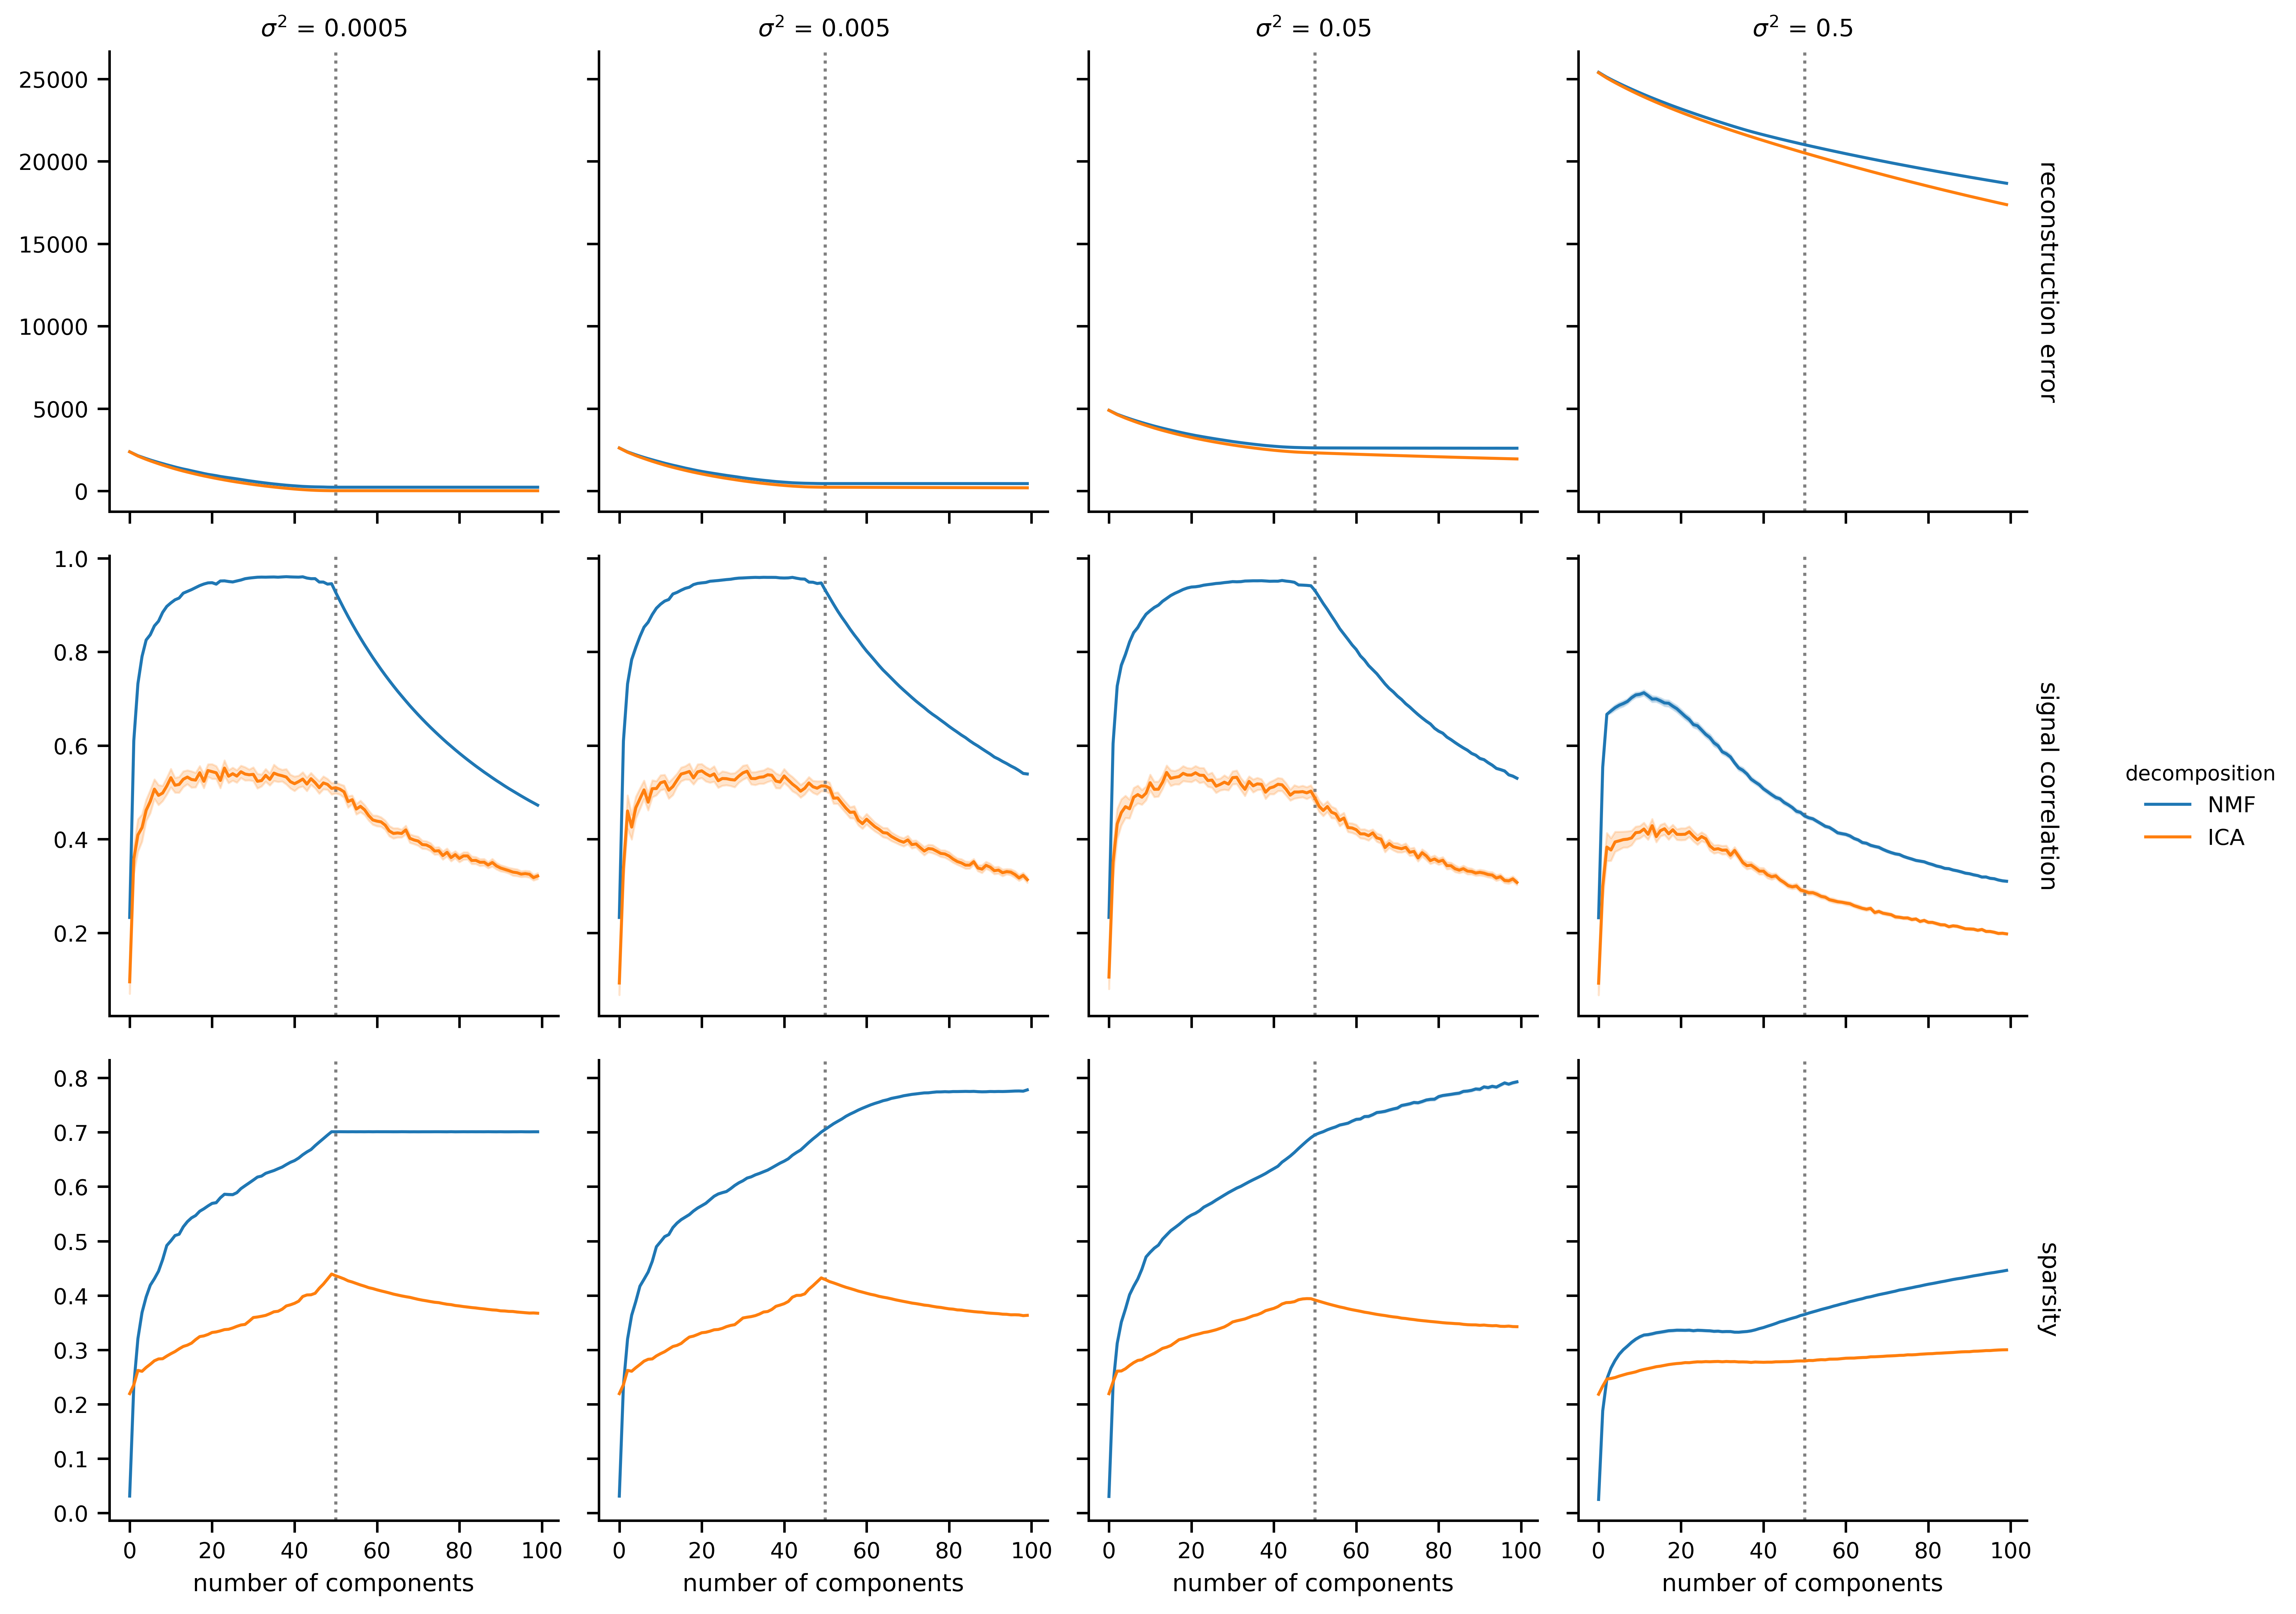

In [57]:
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 500
#plt.figure(figsize=(5,5))

#tidy up names
df_snr.columns = ['$\sigma^2$', 'number of components', 'metric', 'value', 'iteration', 'decomposition']
df_snr = df_snr.replace(["recon_err"],"reconstruction error")
df_snr = df_snr.replace(["signal_corr"],"signal correlation")

g = sns.FacetGrid(df_snr, col="$\sigma^2$", row="metric", sharey="row", hue="decomposition", margin_titles=True)
g.map(plt.axvline, x=n_signals, ls=":", c=".5")
g.map(sns.lineplot, "number of components", "value")
g.add_legend()
[plt.setp(ax.texts, text="") for ax in g.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
g.set_titles(row_template = '{row_name}')
g.set_ylabels("")
plt.savefig("/Users/ppxet1/Documents/OneDrive - The University of Nottingham/NMF paper/snr_sim.png", format='png', dpi=1000)

L1 Regularisation

In [48]:
np.seterr(divide='ignore', invalid='ignore')
l1_ratio = 1
N=100
n_signals =50
alpha = [ 0, 0.1, 0.25, 0.5]
df_alpha = pd.DataFrame()
signals, mixing_matrix = simulation(1200, 1000, n_signals)
data = np.dot(signals, mixing_matrix)
data = data/(np.max(data)+ 0.0001)

for i in range(100):
   

    noisy_data = logit_gaussian(data, np.sqrt(0.05))
    for a in alpha:

        for num_components in range(N):
            model = nmf(n_components=num_components + 1, alpha=a, l1_ratio=l1_ratio)

            W = model.fit_transform(noisy_data)
            H = model.components_
            recon = np.dot(W, H)

            df_alpha = df_alpha.append({
                "alpha": a,
                "number of components": num_components,
                "metric":"reconstruction error",
                "val": np.sum((recon - noisy_data)**2),
                }, ignore_index=True)

            df_alpha = df_alpha.append({
                "alpha": a,
                "number of components": num_components,
                "metric":"signal correlation",
                "val": SignalCorr(signals, W),
                }, ignore_index=True)

            df_alpha = df_alpha.append({
                "alpha": a,
                "number of components": num_components,
                "metric":"sparsity",
                "val": np.nanmean(sparsity(W)),
                }, ignore_index=True)

    i+=1
    
df_alpha.to_csv("/Users/ppxet1/Documents/OneDrive - The University of Nottingham/NMF paper/alpha_sim.csv", index=False)

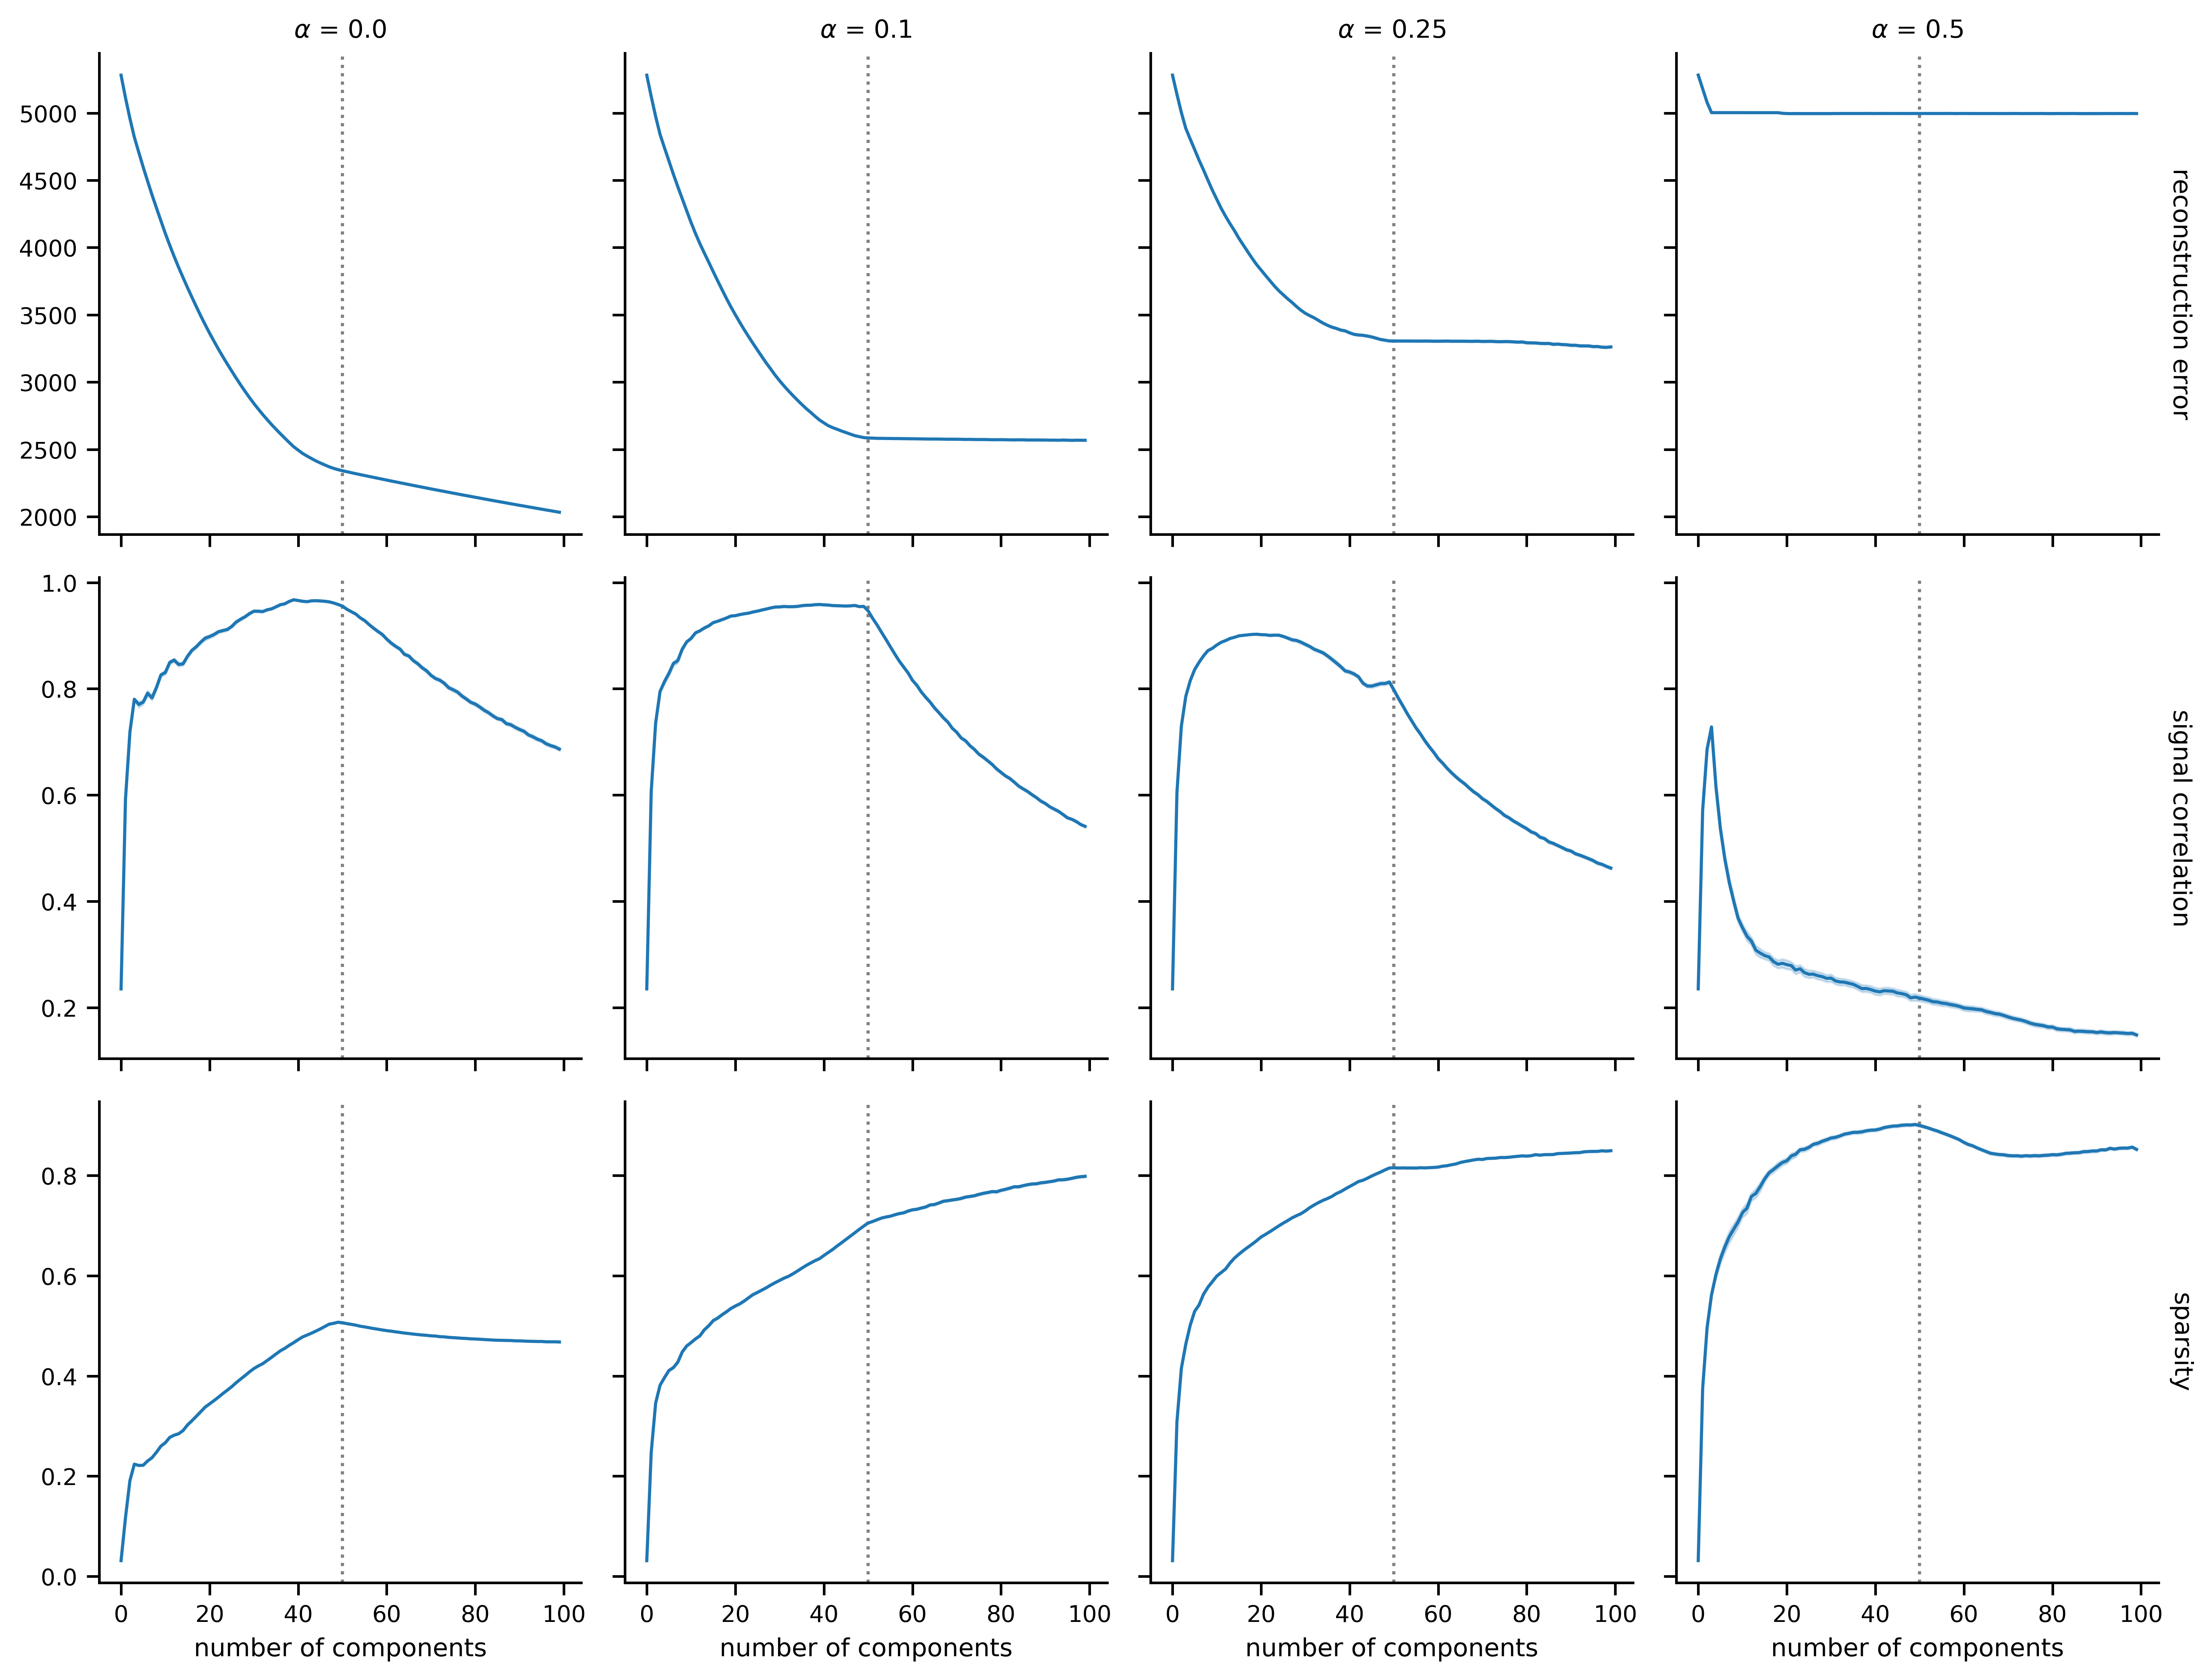

In [49]:
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 500
df_alpha.columns = [r'$ \alpha $', "metric", "number of components", "val"]
g = sns.FacetGrid(df_alpha, col=r'$ \alpha $', row="metric", sharey="row", margin_titles=True)
g.map(plt.axvline, x=n_signals, ls=":", c=".5")
g.map(sns.lineplot, "number of components", "val")
[plt.setp(ax.texts, text="") for ax in g.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
g.set_titles(row_template = '{row_name}')
g.set_ylabels("")
plt.savefig("/Users/ppxet1/Documents/OneDrive - The University of Nottingham/NMF paper/alpha_sim.png", format='png', dpi=1000)

Number of Signals

In [67]:
np.seterr(divide='ignore', invalid='ignore')
alpha = 0.1
l1_ratio = 1
N=100

s = [ 25, 50, 75 ]
df_comp = pd.DataFrame(columns=["number of signals", "number ofcomponents", "metric", "val", "iteration"])

signals_all, mixing_matrix_all = simulation(1200, 1000, 75)
for i in range(100):
    print(i)

    for n_signals in s:

        signals = signals_all[:, :n_signals]
        mixing_matrix = mixing_matrix_all[:n_signals,:]
        data = np.dot(signals, mixing_matrix)
        data = data/(np.max(data)+ 0.0001)
        data = logit_gaussian(data, np.sqrt(0.05))

        for decomposition in "NMF", "ICA":
            for num_components in range(N):
                if decomposition == "NMF":
                    model = nmf(n_components=num_components + 1, alpha=alpha, l1_ratio=l1_ratio)
                    W = model.fit_transform(data)
                    H = model.components_
                    m=0


                else:
                    model = ica(n_components=num_components + 1, max_iter=10000, tol = 0.01)
                    PCA = pca(100)
                    W_ = PCA.fit_transform(data)
                    m = PCA.mean_
                    try:
                        W = model.fit_transform(W_)
                    except:
                        pass
                    H = np.dot(np.linalg.pinv(W), data)


                recon = np.dot(W, H) + m


                df_comp = df_comp.append({
                    "decomposition": decomposition,
                    "number of signals": n_signals,
                    "number of components": num_components,
                    "metric":"reconstruction error",
                    "val": np.sum((recon - data)**2),
                    "iteration":i
                    }, ignore_index=True)

                df_comp = df_comp.append({
                    "decomposition": decomposition,
                    "number of signals": n_signals,
                    "number of components": num_components,
                    "metric":"signal correlation",
                    "val": SignalCorr(signals, W),
                    "iteration":i,
                    }, ignore_index=True)

                df_comp = df_comp.append({
                    "decomposition": decomposition,
                    "number of signals": n_signals,
                    "number of components": num_components,
                    "metric":"sparsity",
                    "val": np.nanmean(sparsity(W)),
                    "iteration":i,
                    }, ignore_index=True)

    i+=1

df_comp.to_csv("/Users/ppxet1/Documents/OneDrive - The University of Nottingham/NMF paper/component_sim.csv", index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


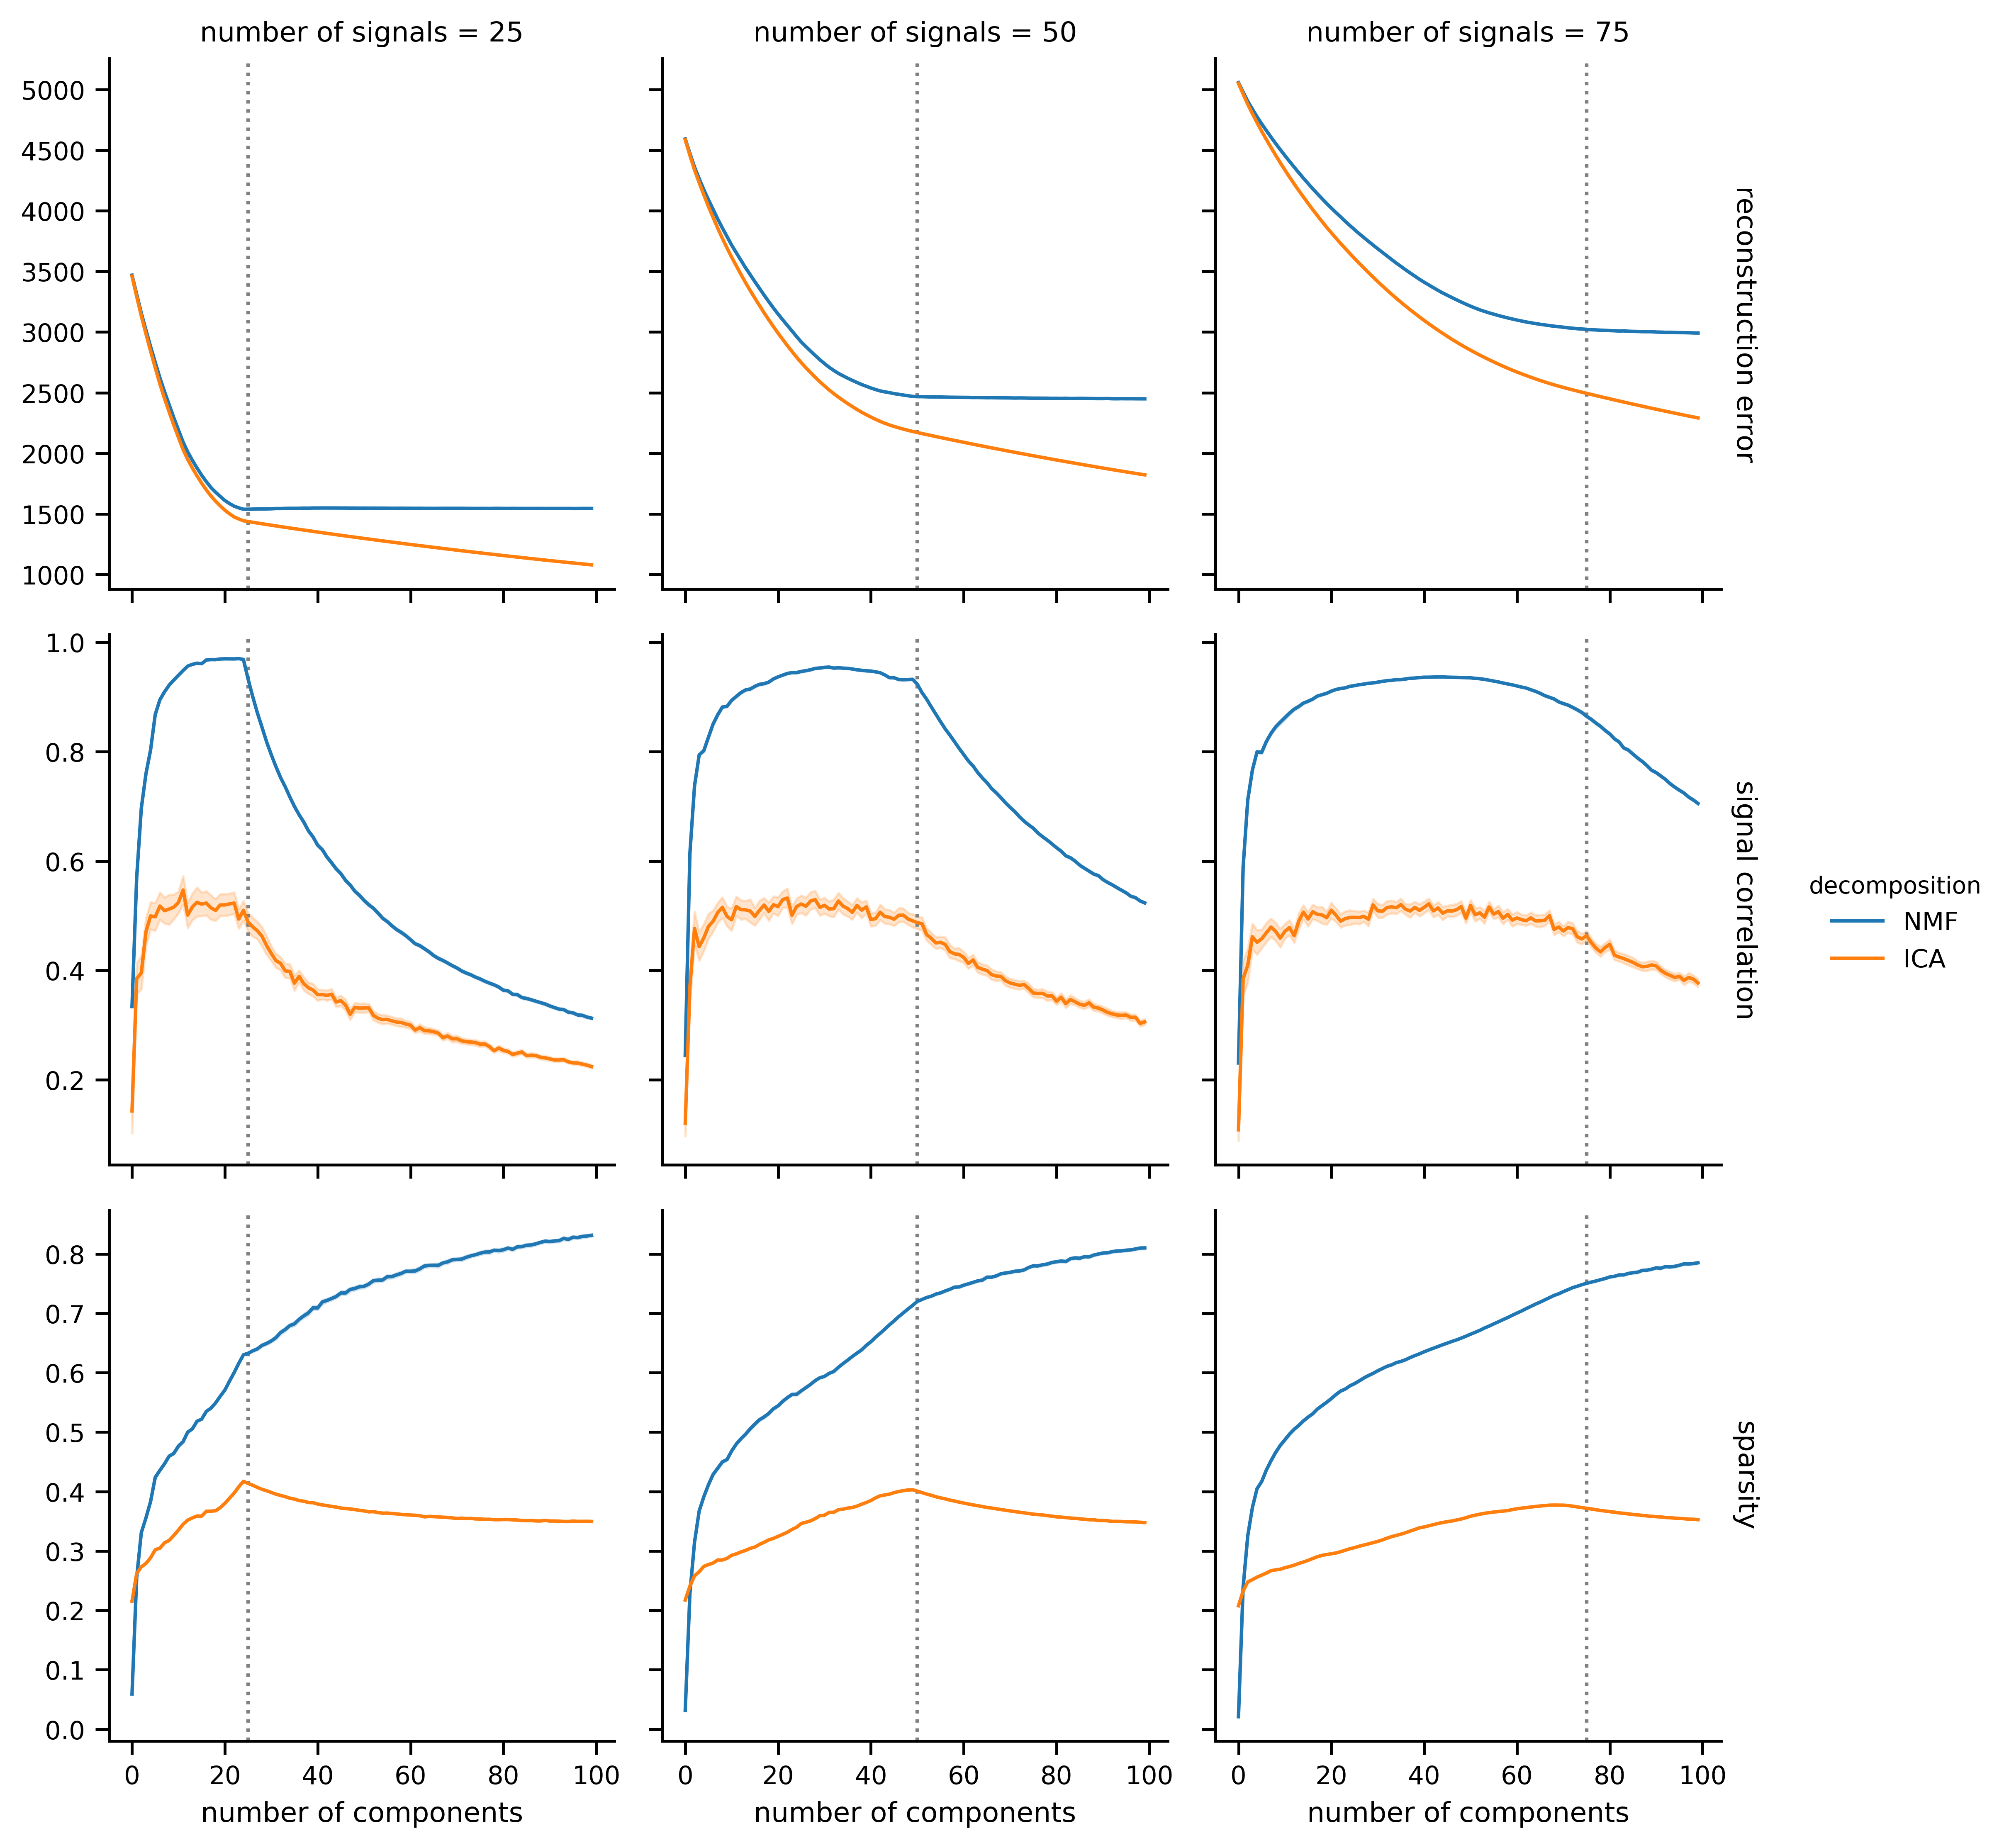

In [68]:
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 500

g = sns.FacetGrid(df_comp, col="number of signals", row="metric", sharey="row", hue="decomposition", margin_titles=True)
for i in range(3):
    g.axes[0,i].axvline(s[i],ls=":", c=".5")
    g.axes[1,i].axvline(s[i],ls=":", c=".5")
    g.axes[2,i].axvline(s[i],ls=":", c=".5")

g.map(sns.lineplot, "number of components", "val")
g.add_legend()
[plt.setp(ax.texts, text="") for ax in g.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
g.set_titles(row_template = '{row_name}')
g.set_ylabels("")
plt.savefig("/Users/ppxet1/Documents/OneDrive - The University of Nottingham/NMF paper/n_signals_sim.png", format='png', dpi=1000)